In [5]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 확인
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset 만들기
import keras
from keras.utils import to_categorical

# Detect Face
import cv2
from scipy.ndimage import zoom

# Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import torch

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-08-05 10:35:42.883628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-05 10:35:42.883645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10896193589601448774
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 locality {
   bus_id: 1
 }
 incarnation: 17571025133157531475
 physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
 xla_global_id: -1]

In [7]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# gpu사용 변수
device = torch.device('mps:0') if torch.backends.mps.is_available() else torch.device('cpu')
device

device(type='mps', index=0)

In [9]:
df = pd.read_csv('./data/face_detect/fer2013.csv')

# 이미지 픽셀 list로 만들기
df['pixels'] = df['pixels'].apply(lambda pixel: np.fromstring(pixel, sep=' '))
df.head()

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


In [10]:
# train test 나누기
train_df = df[df['Usage']=='Training']
test_df = df[df['Usage']=='PublicTest']
print(train_df.shape)
print(test_df.shape)

(28709, 3)
(3589, 3)


In [11]:
shape_x = 48
shape_y = 48

# X_train, y_train, X_test, y_test split
X_train = train_df.iloc[:, 1].values # pixles
y_train = train_df.iloc[:, 0].values # emotion

X_test = test_df.iloc[:, 1].values # pixles
y_test = test_df.iloc[:, 0].values # emotion

# 전체데이터
X = df.iloc[:, 1].values # pixles
y = df.iloc[:, 0].values # emotion

# array([array([....])]) 구조를 바꾸기 위한 np.vstack
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

In [12]:
# 4차원 데이터셋 만들기 (데이터개수, x축, y축, rgb)
X_train_ds = np.reshape(X_train, (X_train.shape[0], shape_x, shape_y, 1))
y_train_ds = np.reshape(y_train, (y_train.shape[0], 1))

X_test_ds = np.reshape(X_test, (X_test.shape[0], shape_x, shape_y, 1))
y_test_ds = np.reshape(y_test, (y_test.shape[0], 1))

print(X_train_ds.shape, y_train_ds.shape)
print(X_test_ds.shape, y_test_ds.shape)

(28709, 48, 48, 1) (28709, 1)
(3589, 48, 48, 1) (3589, 1)


In [13]:
# 데이터타입 float로 변경
train_data = X_train_ds.astype('float32')
test_data = X_test_ds.astype('float32')

# 스케일링
train_data /= 225
test_data /= 225

# y데이터 원핫인코딩
train_labels_onehot = to_categorical(y_train_ds)
test_labels_onehot = to_categorical(y_test_ds)

# input_shape 설정
n_rows, n_cols, n_dims = X_train_ds.shape[1:]
input_shape = (n_rows, n_cols, n_dims)
print(input_shape)

(48, 48, 1)


Text(0.5, 1.0, 'Ground Truth : happy')

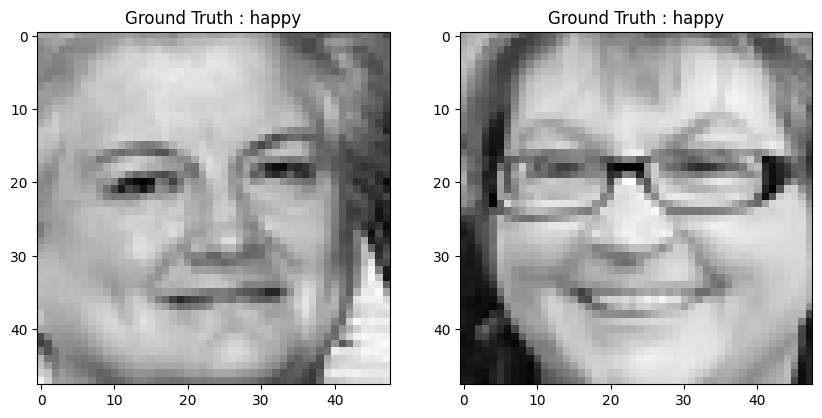

In [14]:
# 라벨 숫자를 문자로 변경
def get_label(argument):
    labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
    return(labels.get(argument, 'Invalid emotion'))
    
# 데이터 시각화
plt.figure(figsize=[10,5])

# Train data 중 100번째 이미지
n=100

plt.subplot(121)
plt.imshow(np.squeeze(X_train_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[n]))))

# Test data 중 100번째 이미지
plt.subplot(122)
plt.imshow(np.squeeze(X_test_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[n]))))

In [15]:
import cv2
import numpy as np
from scipy.fftpack import fft2, ifft2

def detect_face_hybrid(frame):
    # Haar Cascade를 사용한 얼굴 감지
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(gray,
                                                   scaleFactor=1.1,
                                                   minNeighbors=6,
                                                   minSize=(48, 48),
                                                   flags=cv2.CASCADE_SCALE_IMAGE)
    
    coord = []
    for x, y, w, h in detected_faces:
        if w > 100:
            coord.append([x, y, w, h])
    
    return gray, detected_faces, coord

In [16]:
def extract_face_features_hybrid(gray, coord, shape_x=48, shape_y=48):
    new_face = []
    for x, y, w, h in coord:
        # 얼굴 영역 추출
        face = gray[y:y+h, x:x+w]
        
        # 2D 푸리에 변환 적용
        f_transform = fft2(face)
        f_shift = np.fft.fftshift(f_transform)
        
        # 고주파 성분 제거 (저역 통과 필터)
        rows, cols = face.shape
        crow, ccol = rows//2, cols//2
        mask = np.zeros((rows, cols), np.uint8)
        mask[crow-15:crow+15, ccol-15:ccol+15] = 1
        f_shift_filtered = f_shift * mask
        
        # 역 푸리에 변환
        f_ishift = np.fft.ifftshift(f_shift_filtered)
        face_filtered = np.abs(ifft2(f_ishift))
        
        # 크기 조정
        face_resized = cv2.resize(face_filtered, (shape_x, shape_y))
        
        # 정규화
        face_normalized = cv2.normalize(face_resized, None, 0, 1, cv2.NORM_MINMAX)
        
        new_face.append(face_normalized)
    
    return new_face

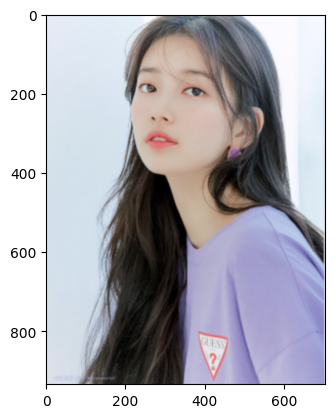

In [17]:
suzy = cv2.imread('./data/face_detect/e_neutral.png')
plt.imshow(cv2.cvtColor(suzy, cv2.COLOR_BGR2RGB))

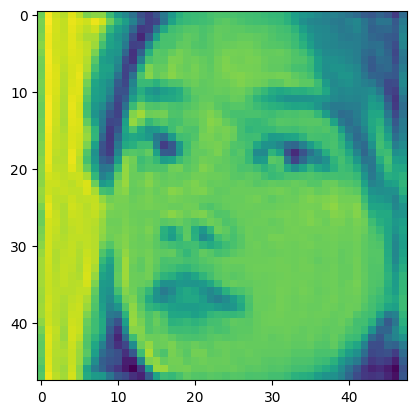

In [18]:
# 얼굴 찾기
gray, detected_faces, coord = detect_face_hybrid(suzy)

# 찾은 얼굴 추출하기
face_zoom = extract_face_features_hybrid(gray, coord)

# 시각화
plt.imshow(face_zoom[0])

In [19]:
def simple_model():
    model = Sequential()
    
    # Input layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    
    # Add layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # Flatten
    model.add(Flatten())
    
    # Fully connected layer
    model.add(Dense(512, activation='relu'))
    
    # Output layer : n_classes=7
    model.add(Dense(7, activation='softmax'))
    
    return model

In [20]:
model = simple_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 64)        36928     
                                                        

2024-08-05 10:36:05.882891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-05 10:36:05.882919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


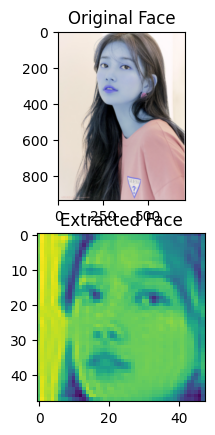

In [21]:
# 각 레이어마다 어떻게 변화하는지 시각화

# 마지막 Dense 레이어 2개를 제외한 레이어별 out 담기 
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# 시각화 할 때 어떤 레이어인지 확인할 수 있도록 레이어 이름 담기
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)
    
# 수지 얼굴 이미지 가져오기
suzy = cv2.imread('./data/face_detect/e_neutral.png')
gray, detected_faces, coord = detect_face_hybrid(suzy)
face_zoom = extract_face_features_hybrid(gray, coord)
face = face_zoom[0]

plt.subplot(211)
plt.title("Original Face")
plt.imshow(suzy)

plt.subplot(212)
plt.title("Extracted Face")
plt.imshow(face)

plt.show()

1/1 [==============================] - 0s 160ms/step


2024-08-05 10:36:07.507862: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-08-05 10:36:07.551593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 112ms/step


2024-08-05 10:36:07.714744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


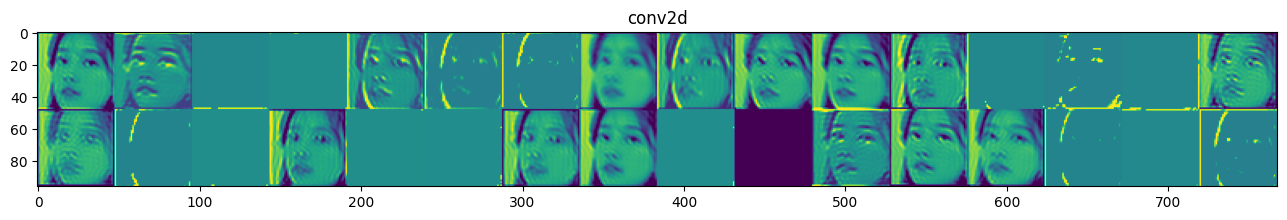

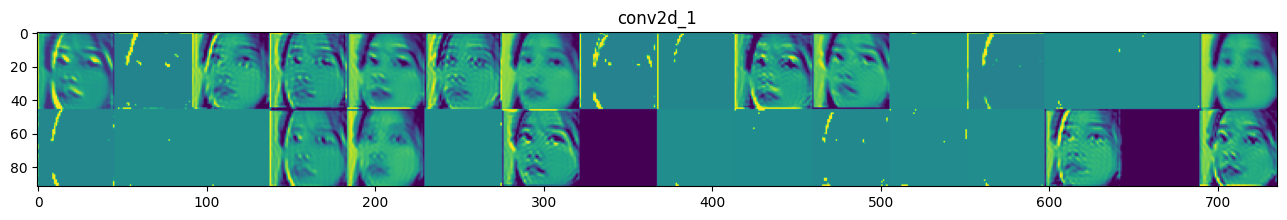

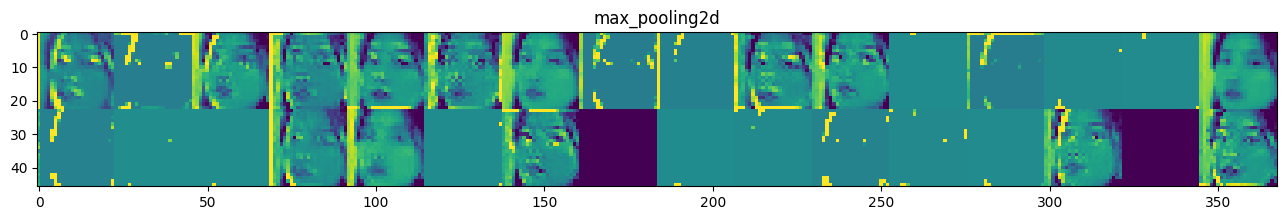

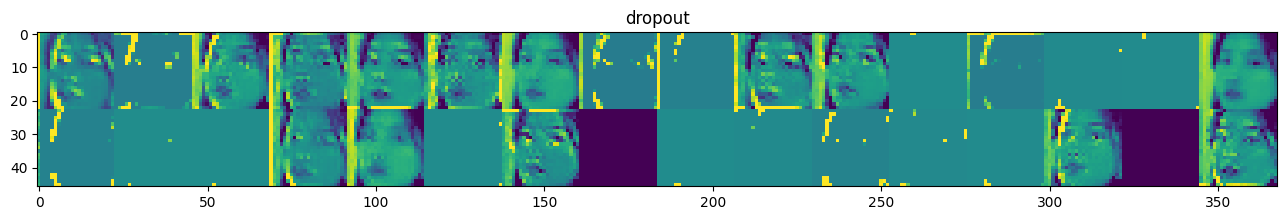

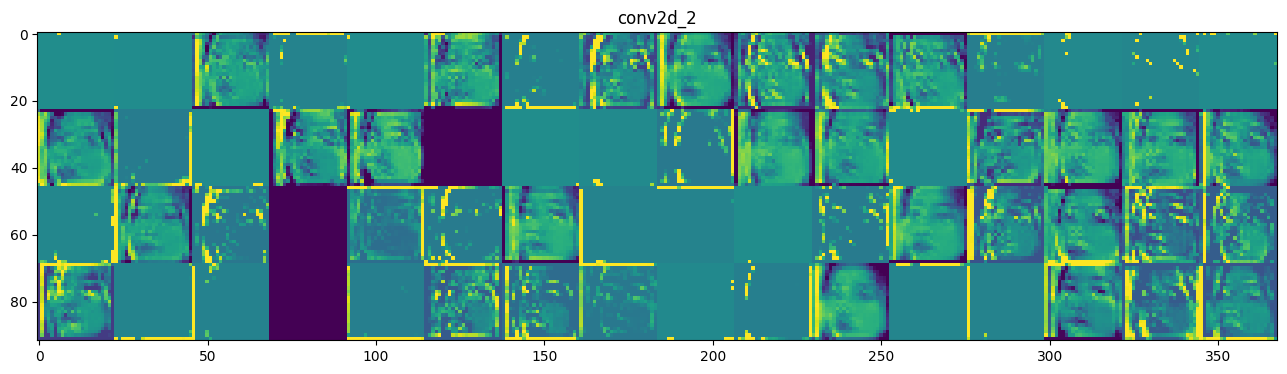

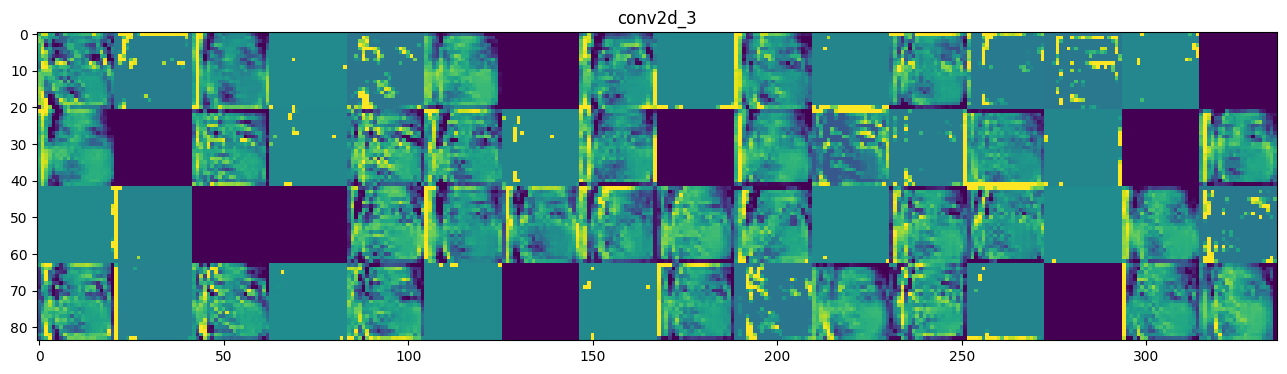

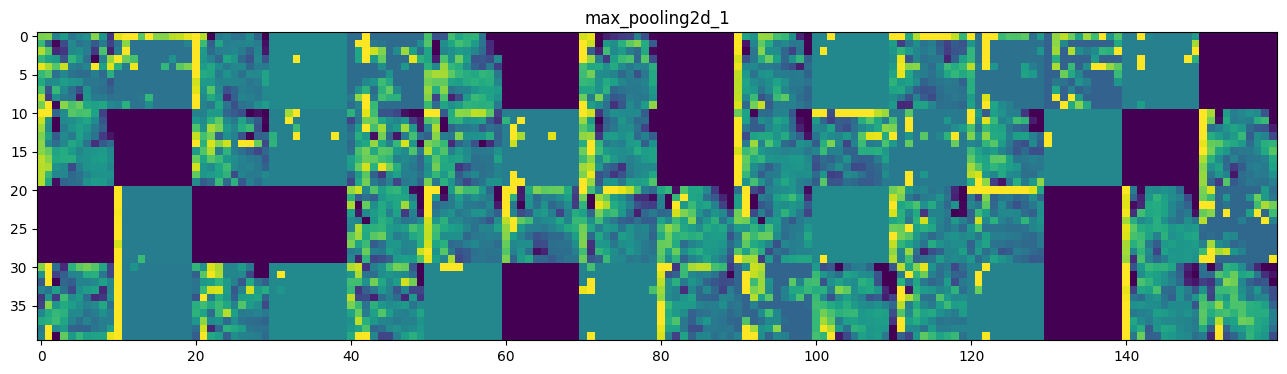

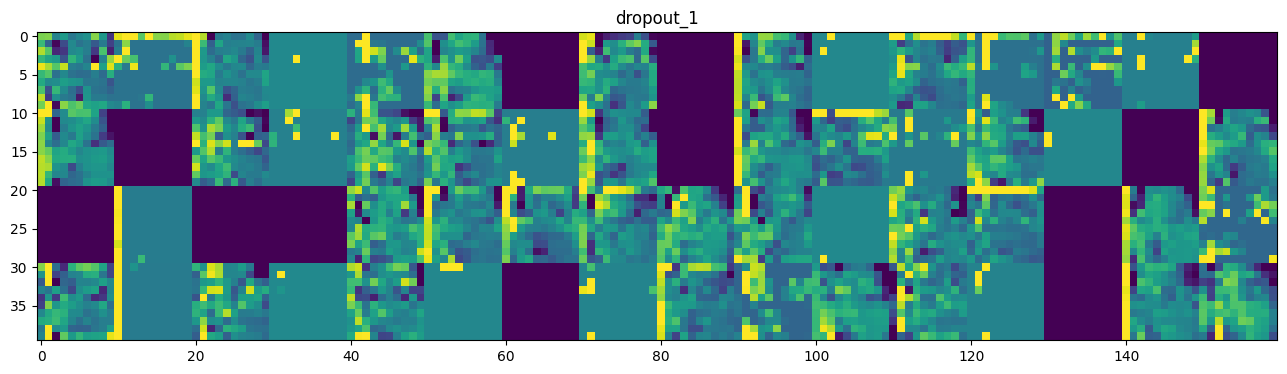

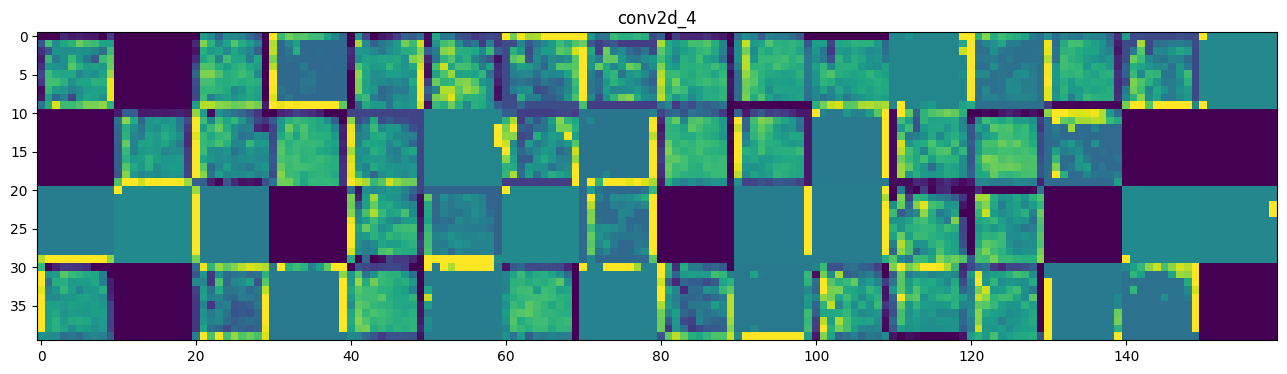

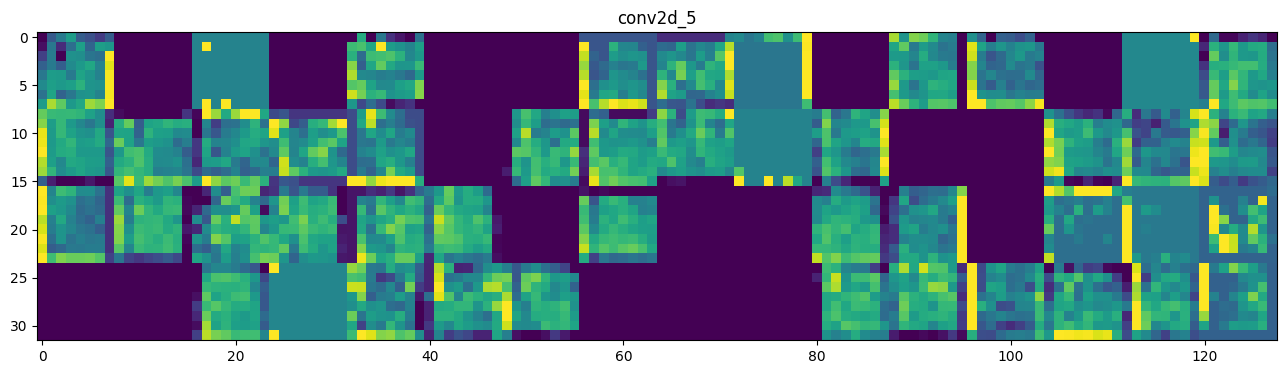

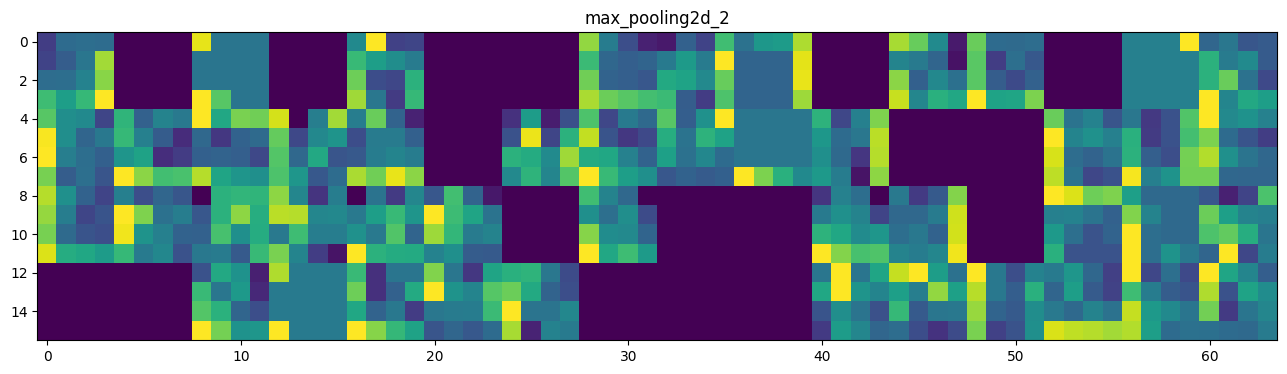

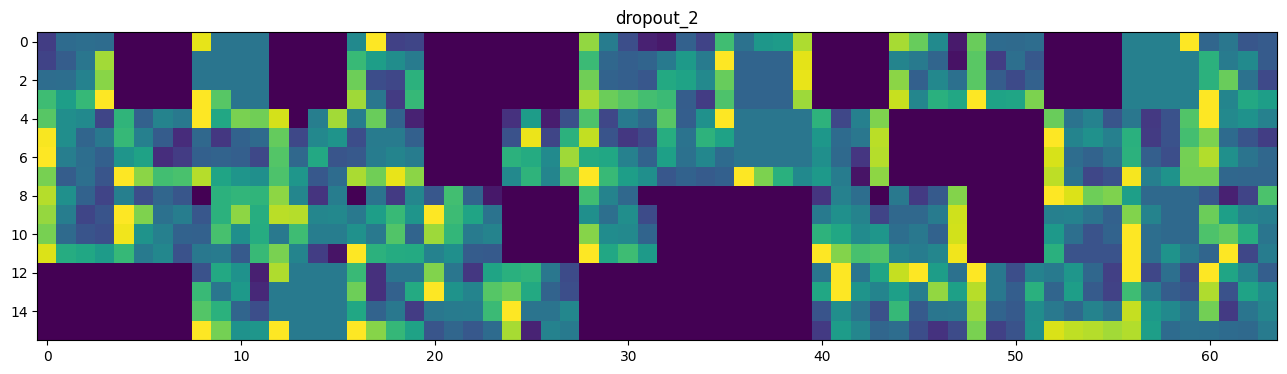

In [22]:
# 수지 얼굴 모델에 넣어서 모델이 어떻게 작동하는지 시각화
to_predict = np.reshape(face.flatten(), (1,48,48,1))
res = model.predict(to_predict)
activations = activation_model.predict(to_predict)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [25]:
# 이미지 데이터 증강
datagen = ImageDataGenerator(zoom_range=0.2,          # 랜덤하게 이미지 줌 하는 비율
                             rotation_range=10,       # 램덤하게 이미지 회전하는 비율 (0도~180도)
                             width_shift_range=0.1,   # 랜덤하게 이미지 가로로 이동하는 비율
                             height_shift_range=0.1,  # 랜덤하게 이미지 세로로 이동하는 비율
                             horizontal_flip=True,    # 랜덤하게 이미지 수평 뒤집기
                             vertical_flip=False)     # 랜덤하게 이미지 수직 뒤집기
                             
# 모델 학습을 위한 파라미터 설정
batch_size = 256
n_epochs = 10
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(datagen.flow(train_data, train_labels_onehot, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(train_data.shape[0]/float(batch_size))),
                              epochs=n_epochs,
                              validation_data=(test_data, test_labels_onehot)
                             )

Epoch 1/10


2024-08-05 10:37:30.528010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


112/113 [============================>.] - ETA: 0s - loss: 1.7504 - accuracy: 0.2779

2024-08-05 10:37:36.033471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 7s 57ms/step - loss: 1.7499 - accuracy: 0.2780 - val_loss: 1.6577 - val_accuracy: 0.3530
Epoch 2/10
113/113 [==============================] - 6s 53ms/step - loss: 1.6688 - accuracy: 0.3311 - val_loss: 1.5169 - val_accuracy: 0.4138
Epoch 3/10
113/113 [==============================] - 6s 52ms/step - loss: 1.5793 - accuracy: 0.3800 - val_loss: 1.4026 - val_accuracy: 0.4650
Epoch 4/10
113/113 [==============================] - 6s 52ms/step - loss: 1.4848 - accuracy: 0.4201 - val_loss: 1.4087 - val_accuracy: 0.4561
Epoch 5/10
113/113 [==============================] - 6s 53ms/step - loss: 1.4208 - accuracy: 0.4496 - val_loss: 1.2854 - val_accuracy: 0.5063
Epoch 6/10
113/113 [==============================] - 6s 52ms/step - loss: 1.3607 - accuracy: 0.4774 - val_loss: 1.2620 - val_accuracy: 0.5149
Epoch 7/10
113/113 [==============================] - 6s 52ms/step - loss: 1.3263 - accuracy: 0.4939 - val_loss: 1.1988 - val_accuracy: 0.5436
Epoch 8/10

In [ ]:
# SavedModel 형식으로 저장
import tensorflow as tf
tf.saved_model.save(model, './face-emotion-model/fourier')

# 나중에 SavedModel 불러오기
loaded_model = tf.saved_model.load('./face-emotion-model/fourier')

In [ ]:
# 전체 모델 저장
model.save('./face-emotion-model/fourier-ver/model.h5')

# 나중에 모델 불러오기
# from tensorflow.keras.models import load_model
# loaded_model = load_model('my_model.h5')

Text(0.5, 1.0, 'Accuracy Curves')

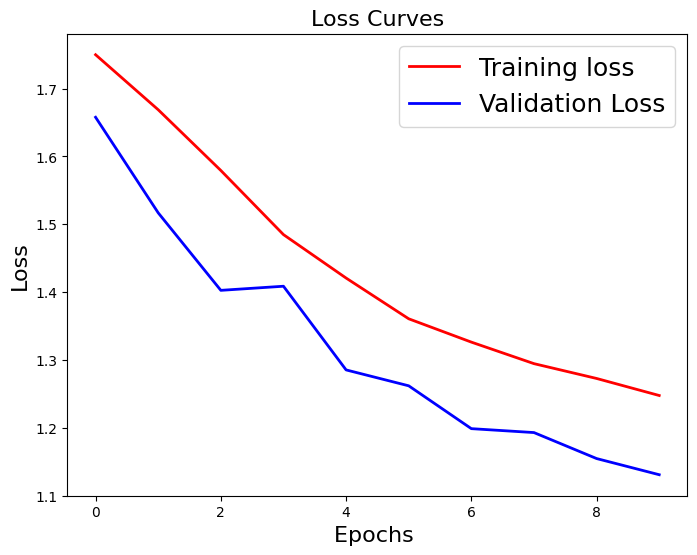

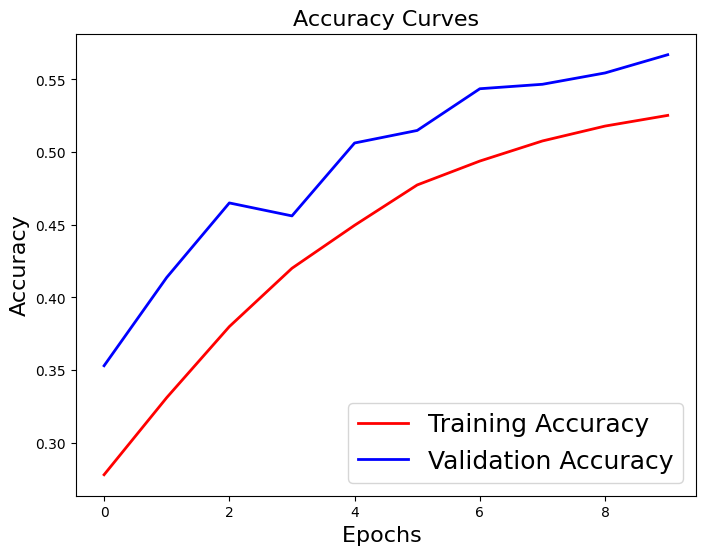

In [26]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
# 원본이미지 확인
face = cv2.imread('./data/face_detect/1.png')

# 얼굴 추출
gray, detected_faces, coord = detect_face_hybrid(face)
face_zoom = extract_face_features_hybrid(gray, coord)

# 모델 추론
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'angry'
elif result == 1:
    emotion = 'disgust'
elif result == 2:
    emotion = 'fear'
elif result == 3:
    emotion = 'happy'
elif result == 4:
    emotion = 'sad'
elif result == 5:
    emotion = 'surprise'
elif result == 6:
    emotion = 'neutral'
    
# 시각화
plt.subplot(121)
plt.title("Original Face")
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_zoom[0])

In [ ]:
# 감정 레이블 매핑
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# 이미지 처리 및 시각화 함수
def process_and_visualize(image_path):
    # 원본 이미지 읽기
    face = cv2.imread(image_path)
    
    # 얼굴 추출
    gray, detected_faces, coord = detect_face_hybrid(face)
    face_zoom = extract_face_features_hybrid(gray, coord)
    
    if len(face_zoom) == 0:
        print(f"No face detected in {image_path}")
        return
    
    # 모델 추론
    input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
    output_data = model.predict(input_data)
    result = np.argmax(output_data)
    
    # 결과 문자로 변환
    emotion = emotion_labels[result]
    
    # 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.title("Original Face")
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(122)
    plt.title(f"Extracted Face : {emotion}")
    plt.imshow(face_zoom[0], cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 1.png부터 7.png까지 반복 처리
for i in range(1, 7):
    image_path = f'./data/face_detect/{i}.png'
    print(f"Processing image: {image_path}")
    process_and_visualize(image_path)